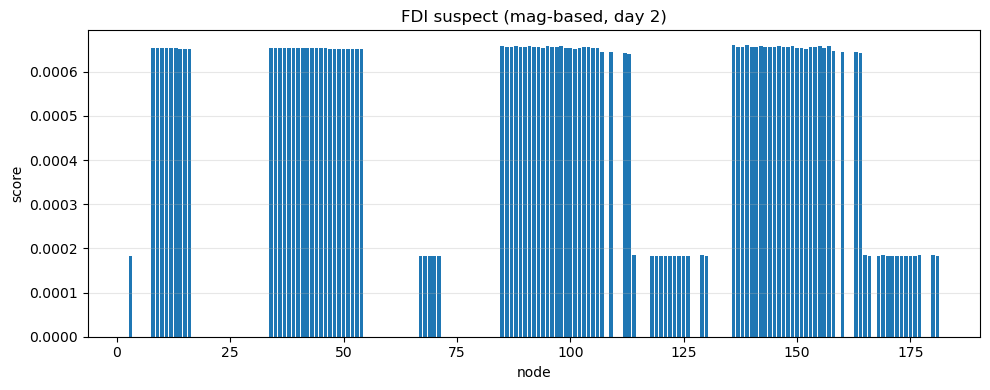

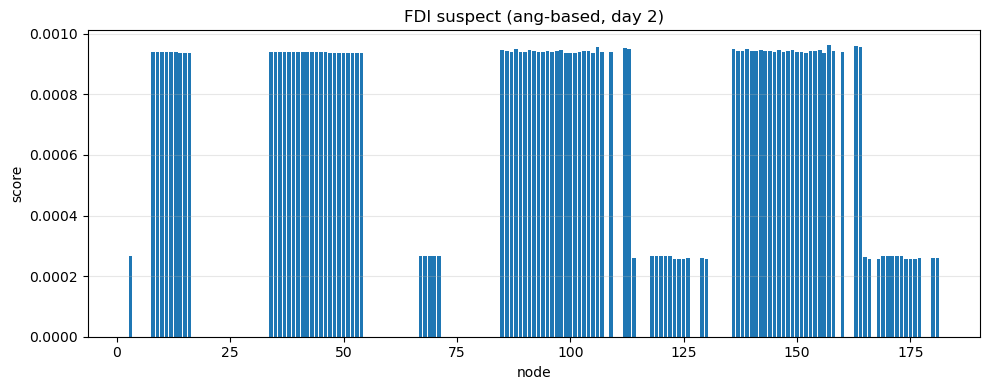

In [13]:
import glob
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

folder = "data"
pkls = os.path.join(folder, "data_day*.pkl")
CUTOFF = 1e-3       # consider node open if mag & ang < this

def day_matrix(info):
    v_sch = info['sch_v']
    t_sch = info['sch_θ']
    v_att = info['attack_v']
    t_att = info['attack_θ']
    steps = [f"x{x}" for x in range(37, 62)]            # attack window every day
    V_sch = np.stack([v_sch[k] for k in steps], axis=1) # shape (187, 25)
    T_sch = np.stack([t_sch[k] for k in steps], axis=1)
    # fill attack's missing steps with sch
    V_att = np.stack([v_att.get(k, v_sch[k]) for k in steps], axis=1)
    T_att = np.stack([t_att.get(k, t_sch[k]) for k in steps], axis=1)
    return V_sch, T_sch, V_att, T_att

def all_feat(V_sch, T_sch, V_att, T_att, d):
    n_node = V_sch.shape[0]
    dif_v = V_att - V_sch   ## signed: SPATIAL corr analysis later (directional propagation, IDK)
    dif_t = T_att - T_sch
    abs_v = np.abs(dif_v)
    abs_t = np.abs(dif_t)

    ## exclude invalid nodes (no power flow)
    valid_msk = ~((np.max(np.abs(V_sch), axis=1) < CUTOFF) & (np.max(np.abs(T_sch), axis=1) < CUTOFF))
    valid_msk = np.asarray(valid_msk, dtype=bool)

    # per-node stats
    peak_v = np.max(abs_v, axis=1)
    peak_v_idx = np.argmax(abs_v, axis=1)
    mean_abs_v = np.mean(abs_v, axis=1)
    std_v = np.std(abs_v, axis=1)
    peak_th = np.max(abs_t, axis=1)
    mean_abs_th = np.mean(abs_t, axis=1)
    std_th = np.std(abs_t, axis=1)
    energy_v = np.sum(dif_v**2, axis=1) / V_sch.shape[1]    #! by GPT

    # correlation matrix on abs voltage diff among valid nodes
    valid_nodes = np.where(valid_msk)[0]
    corr_max = np.zeros(n_node)
    if len(valid_nodes) > 1:
        sub = abs_v[valid_nodes, :]
        # exclude const rows (zero variance)
        nnz = np.std(sub, axis=1) > 1e-3
        if nnz.sum() > 1:
            corr = np.corrcoef(sub[nnz])
            # map back
            idx_map = valid_nodes[nnz]
            for j, orij in enumerate(idx_map):
                row = corr[j]
                # exclude self
                corr_max[orij] = np.max(np.delete(row, j)) if row.size > 1 else 0.0
    corr_max = np.nan_to_num(corr_max, nan=0.0)

    corr_max_th = np.zeros(n_node)
    if len(valid_nodes) > 1:
        sub = abs_t[valid_nodes, :]
        nnz = np.std(sub, axis=1) > 1e-3
        if nnz.sum() > 1:
            corr = np.corrcoef(sub[nnz])
            idx_map = valid_nodes[nnz]
            for j, orij in enumerate(idx_map):
                row_corr = corr[j]
                corr_max_th[orij] = np.max(np.delete(row_corr, j)) if row_corr.size > 1 else 0.0
    corr_max_th = np.nan_to_num(corr_max_th, nan=0.0)

    rows = []
    for n in range(n_node):
        if not valid_msk[n] or np.std(V_sch[n, :]) < 1e-3:
            continue
        row = {
            "day": d,
            "node": int(n),
            "peak_v": float(peak_v[n]),
            "peak_v_time": int(peak_v_idx[n]),
            "mean_abs_v": float(mean_abs_v[n]),
            "std_v": float(std_v[n]),
            "energy_v": float(energy_v[n]),
            "peak_th": float(peak_th[n]),
            "mean_abs_th": float(mean_abs_th[n]),
            "std_th": float(std_th[n]),
            "max_corr": float(corr_max[n]),
            "max_corr_th": float(corr_max_th[n])
        }
        # localization score: large peak & not highly correlated
        row["score"] = row["peak_v"] * (1.0 - row["max_corr"])
        row["score_th"] = row["peak_th"] * (1.0 - row["max_corr_th"])
        rows.append(row)
    return rows

# batch process
features = []
for pkl in sorted(glob.glob(pkls)):
    d = int(pkl.split('day')[1].split('.')[0])
    with open(pkl, "rb") as f:
       data = pickle.load(f)
    V_sch, T_sch, V_att, T_att = day_matrix(data)
    features += all_feat(V_sch, T_sch, V_att, T_att, d)

feat = pd.DataFrame(features)
# feat.to_csv(os.path.join(folder, "daily_nodal_features.csv"), index=False)
# print("done")

day = 2
df_day = feat[feat["day"] == day].copy()

plt.figure(figsize=(10,4))
plt.bar(df_day["node"], df_day["score"])
plt.xlabel("node")
plt.ylabel("score")
plt.title(f"FDI suspect (mag-based, day {day})")
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(df_day["node"], df_day["score_th"])
plt.xlabel("node")
plt.ylabel("score")
plt.title(f"FDI suspect (ang-based, day {day})")
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

N_PCA = 6
CLUSTERS = 3

# scale features for clustering/pca
feat_cols = ["peak_v", "mean_abs_v", "std_v", "energy_v", "peak_th", "mean_abs_th", "std_th", "score"]
scaler = RobustScaler()
if not feat.empty:
    feat[feat_cols] = scaler.fit_transform(feat[feat_cols])

    # PCA pattern extraction
    pca = PCA(n_components=min(N_PCA, len(feat_cols)))
    Xp = pca.fit_transform(feat[feat_cols])
    for i in range(Xp.shape[1]):
        feat[f"pca_{i + 1}"] = Xp[:, i]

    # clustering of nodes by features per day (global clusters)
    kmeans = KMeans(n_clusters=CLUSTERS, random_state=0).fit(feat[feat_cols])
    feat["cluster"] = kmeans.labels_

    ## unfinished

In [ ]:
# GAE unsupervised approach
